In [11]:
%matplotlib inline

In [13]:
import numpy as np
import scipy as sp
import scipy.integrate as spint
import pylab as plt
import xraylib
from glob import glob
import os
import math
import sys
import scipy.signal 

from __future__ import print_function, division
#from skimage.io import imread
from skimage import data_dir
from skimage.transform import radon, rescale


In [2]:
# моделирование спектра тормозного излучения
def intensity(E, Ek):    
    i = 10
    z=42 # порядковый номер элемента анода(молибден)
    res = z*i*(Ek*E/12.39)**2*(Ek-E)/12.39
    return res

# моделирование спектра тормозного излучения для ц.м.
def CMfunc(E, Ek):    
    return intensity(E, Ek)*E

# моделирование спектра тормозного излучения для E^3
def E3func(E, Ek):
    return intensity(E, Ek)*E**3

def E3(E):   
    return E**3

def absorb(E, material, s, r): 
    """
    This function calculate the intensity of the radiation given absorption.
    
    :param E: voltage x-ray tube
    :param material: absorbing layer
    :param s: the thickness of the absorbing layer
    :returns: intensity with absorption
    """
    if hasattr(E, '__iter__'):
        res = [np.exp(-xraylib.CS_Total_CP(material, e)*r*s) for e in E]
    else:
        res = np.exp(-xraylib.CS_Total_CP(material, E)*r*s) 
    return np.asarray(res)

# поглощение
def absfunc(E, Ek, material1, material2, s1, s2, r1, r2):
    
    """
    This function calculate the intensity of the radiation given absorption.
    
    :param E: voltage x-ray tube
    :param material: absorbing layer
    :param s: the thickness of the absorbing layer
    :returns: intensity with absorption
    """
    res = intensity(E, Ek)
    res *= absorb(E, material1, s1, r1)
    res *= absorb(E, material2, s2, r2)
    return res

Text(0,0.5,'Intensity')

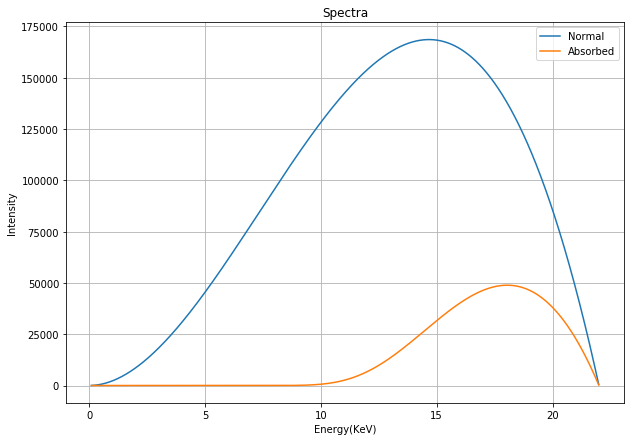

In [3]:
# спектр поглощенного(на 1 см воды) и непоглощенного излучения
Ekr = 22 #np.arange(10, 100, 10)

plt.figure(figsize=(10,7))
E = np.arange(0.1, Ekr, 0.01)
spectrum = intensity(E, Ekr)
Ea = spectrum*absorb(E, 'H2O', 1, 1)

plt.plot(E, spectrum, label='Normal')
plt.plot(E, Ea, label='Absorbed')
plt.grid(True)
plt.legend(loc=0)
plt.title('Spectra')
plt.xlabel('Energy(KeV)')
plt.ylabel('Intensity')



Text(0,0.5,'Attitude')

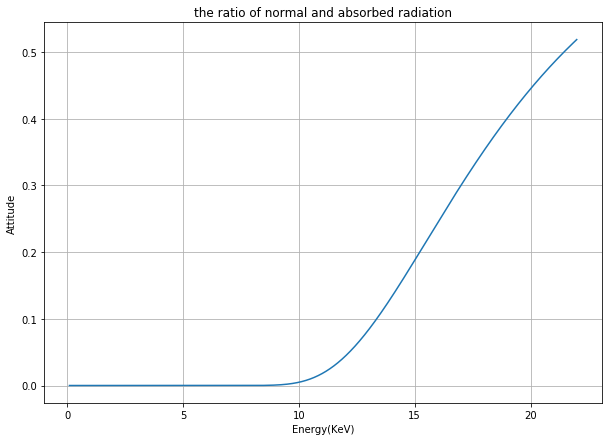

In [4]:
plt.figure(figsize=(10,7))
Eo = Ea/spectrum 

plt.plot(E, Eo)
plt.grid(True)
# plt.legend(loc=0)
plt.title('the ratio of normal and absorbed radiation')
plt.xlabel('Energy(KeV)')
plt.ylabel('Attitude')



13.2
888 1111 1333


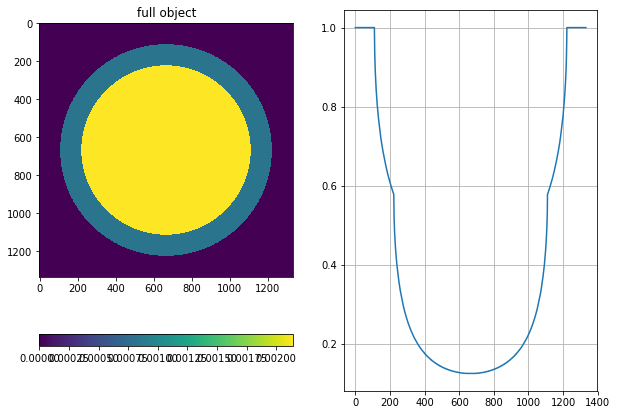

In [5]:
# заполнение двумерного массива интенсивностей при расчете на энергии центра масс спектра
def get_mu(E, material, density):
    return xraylib.CS_Total_CP(material, E)*density*0.1
    
def get_object_cut(E, pixel_size = 0.009):
    water_diameter = int(8/pixel_size)  # 8 mm
    ependorf_diameter = int(10/pixel_size) # 10 mm
    full_field_size =  int(12/pixel_size) # 360 
    print(water_diameter,  ependorf_diameter, full_field_size)

    full_field = np.zeros((full_field_size, full_field_size), dtype='float32')

    X,Y = np.meshgrid(np.arange(full_field_size)-full_field_size//2,
                      np.arange(full_field_size)-full_field_size//2)

    water = X**2+Y**2 < (water_diameter/2)**2
    water = water.astype('float32')
    ependorf = X**2+Y**2 < (ependorf_diameter/2)**2
    ependorf = ependorf.astype('float32')
    ependorf -= water
    
    full_object = water * get_mu(E, 'H2O', 1) * pixel_size + ependorf * get_mu(E, 'C3H6', 0.91) * pixel_size
    return full_object

def get_object_projection(object_cut):
    return np.exp(-object_cut.sum(axis=-1))
    

M1 = spint.quad(CMfunc, 0, Ekr, args=(Ekr))
M2 = spint.quad(intensity, 0, Ekr, args=(Ekr))

E = M1[0]/M2[0]
print(E)

full_object = get_object_cut(E)
projection = get_object_projection(full_object)

plt.figure(figsize=(10,7))
plt.subplot(121)
plt.title('full object')
plt.imshow(full_object)
plt.colorbar(orientation='horizontal')

plt.subplot(122)
plt.plot(projection)
plt.grid()
plt.show()

14.666666666666666
888 1111 1333


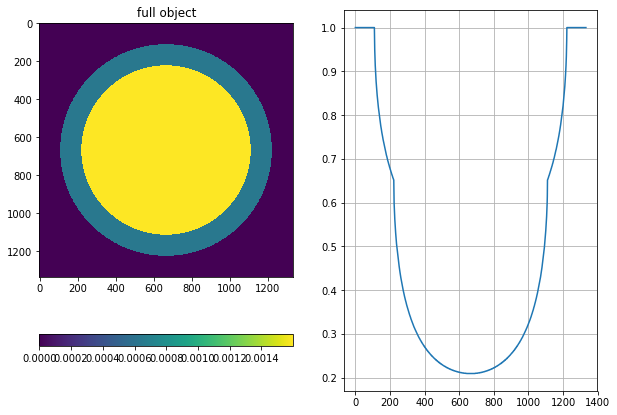

In [6]:
E = Ekr*2./3
print(E)

full_object = get_object_cut(E)
projection = get_object_projection(full_object)

plt.figure(figsize=(10,7))
plt.subplot(121)
plt.title('full object')
plt.imshow(full_object)
plt.colorbar(orientation='horizontal')

plt.subplot(122)
plt.plot(projection)
plt.grid()
plt.show()

In [7]:
ek=22.
energy = np.arange(0, ek, 0.01)
spectrum = intensity(energy, ek)
spectrum /= sp.trapz(spectrum, energy)

s1 = spectrum*energy**1
s1 /= sp.trapz(s1,energy)

s3 = spectrum*energy**3
s3 /= sp.trapz(s3,energy)

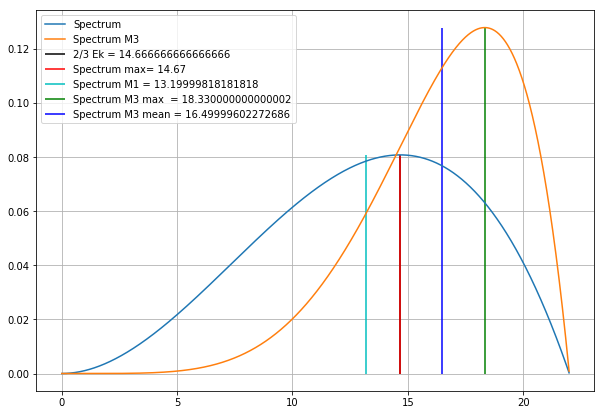

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(energy, spectrum, label='Spectrum')
plt.plot(energy, s3, label='Spectrum M3')
plt.vlines(ek*2./3, 0, spectrum.max(), 
           label=f'2/3 Ek = {ek*2./3}')
plt.vlines(energy[np.argmax(spectrum)], 0, spectrum.max(), 'r', 
           label = f'Spectrum max= {energy[np.argmax(spectrum)]}' )
plt.vlines(np.average(energy, weights=spectrum), 0, spectrum.max(), 'c', 
           label = f'Spectrum M1 = {np.average(energy, weights=spectrum)}')
plt.vlines(energy[np.argmax(s3)], 0, s3.max(), 'g', 
           label = f'Spectrum M3 max  = {energy[np.argmax(s3)]}')
plt.vlines(np.average(energy, weights=s3), 0, s3.max(), 'b', 
           label = f'Spectrum M3 mean = {np.average(energy, weights=s3)}')
plt.grid()
plt.legend(loc=0)

In [9]:
A = glob('data*.txt')

C:\Artem\python3.6\envs\py2\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
C:\Artem\python3.6\envs\py2\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Artem\python3.6\envs\py2\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


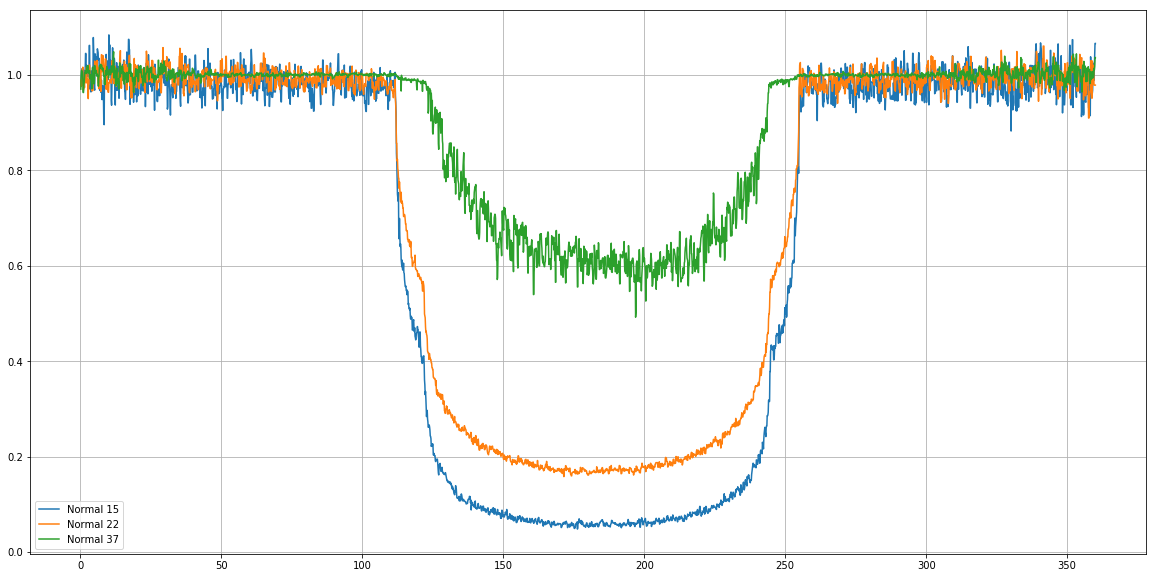

In [10]:
plt.figure(figsize=(20,10))
plt.hold(True)
plt.grid(True)

tmp = 360./3000
width = []

for i in range(1, 3001, 1):
    width.append(tmp*i) #координата по оси Х

for AA in [A[0], A[7], A[14]]:
    AAA = np.loadtxt(AA)
    cut_data = AAA[AAA.shape[0]//2]
    cut_data = scipy.signal.medfilt(cut_data, kernel_size=3)
    AA = AA.replace("data","empty")
    AAA = np.loadtxt(AA)
    cut_empty = AAA[AAA.shape[0]//2]
    cut_empty = scipy.signal.medfilt(cut_empty, kernel_size=3)
    AA = AA.replace("empty", "dark")
    AAA = np.loadtxt(AA)
    cut_dark = AAA[AAA.shape[0]//2]
    cut_dark = scipy.signal.medfilt(cut_dark, kernel_size=3)
    plt.plot(width, (cut_data - cut_dark)/(cut_empty - cut_dark), label = 'Normal ' + AA[-9:-7])


plt.legend(loc=0)